# Whale Identification

The purpose of this model is create a whale identification model based on previous data. First step is prepare the data to be digested by the model.

# Organizing the Dataset

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from itertools import combinations, chain
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class WhaleDataset(Dataset):
    """
    Creates the dataset to train the model.
    """
    def __init__(self, csv_file, root_dir, transforms, split=.8,pos_ratio=0.619):
        """     
        Args: 
            root_dir (string): Path to diretory with images.
            csv_file (string): Path to csv with all the images.
            kind (string): train ratio of data.
            transforms (list): Optional list with train/test transforms to be applied to images.
            pos_ratio (float): Ratio of positive/negative matches present in dataset. (not implemented)
        """
        # Prepare DataFrame with the pair of images
        combined_pos_list = []
        whales_frame = pd.read_csv(csv_file)
        # Series with list of images for each ID
        pos_img_series = whales_frame.groupby('Id').agg(lambda x: ",".join(x)).drop("new_whale")["Image"]
        # Series of non-matching images
        false_img_series = whales_frame.groupby('Id').agg(lambda x: x.iloc[0])["Image"]
        # Calculates combinations of positive matches
        for idx, v in pos_img_series.iteritems():
            imgs = v.split(",")
            combined = combinations(imgs, 2)
            combined_pos_list.append(combined)
        
        # Positive matches
        positive = pd.DataFrame(list(chain(*combined_pos_list)), columns=["image_1", "image_2"])
        positive["label"] = 1
        
        # Calculates negative matches for all idx
        combined_neg = combinations(false_img_series, 2)
        negative = pd.DataFrame(list(combined_neg), columns=["image_1", "image_2"])
        negative["label"] = 0
        
        
        # Join both frames
        self.data_raw = pd.concat([positive, negative], axis=0, join='outer', ignore_index=True)
        
        # Shuffle
        self.data_shuffled = self.data_raw.sample(frac=1).reset_index(drop=True).copy()
        # Split in train/test
        split_pos = int(len(self.data_raw) * split)
        self.train_data = self.data_shuffled.iloc[:split_pos, :]
        self.test_data = self.data_shuffled.iloc[split_pos:, :]
            
        self.root_dir = root_dir
        
        # Transforms
        self.transform = None
        self.transforms = transforms
        
        self.set_mode("train")
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Load images
        img_1_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 0])
        img_2_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 1])
        img_1 = Image.open(img_1_path).convert('RGB')
        img_2 = Image.open(img_2_path).convert('RGB')
        
        
        # Data augmentation
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        
        # Label for image pair
        label = self.data.iloc[idx, 2]
        
        # Output
        sample = (img_1, img_2, label)
        
        return sample
    
    def set_mode(self, mode):
        if mode == "train":
            self.data = self.train_data
            self.transform = self.transforms[0]
        elif mode == "test":
            self.data = self.test_data
            self.transform = self.transforms[1]
        else:
            raise "Mode shoud be 'train' or 'test'."

In [3]:
csv_file = 'humpback-whale-identification/train.csv'
root_dir = 'humpback-whale-identification/train'
# data augmentation
train_transform = T.Compose([T.ColorJitter(.25, .25, .25,),
                             T.Resize(500),
                             T.RandomRotation(5),
                             T.FiveCrop((320)),
                             T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops]))
                            ])

test_transform = T.Compose([T.Resize(500),
                            T.FiveCrop((320)),
                            T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops]))
                           ])

whale_dataset = WhaleDataset(csv_file, root_dir, transforms=[train_transform, test_transform])

In [4]:
data_loader = DataLoader(whale_dataset,
                         batch_size=1,
                         shuffle=True)

In [5]:
whale_dataset.set_mode("train")
len(whale_dataset)

10073957

In [7]:
whale_dataset.set_mode("test")
len(whale_dataset)

2518490

torch.Size([1, 5, 3, 320, 320])
tensor([0])


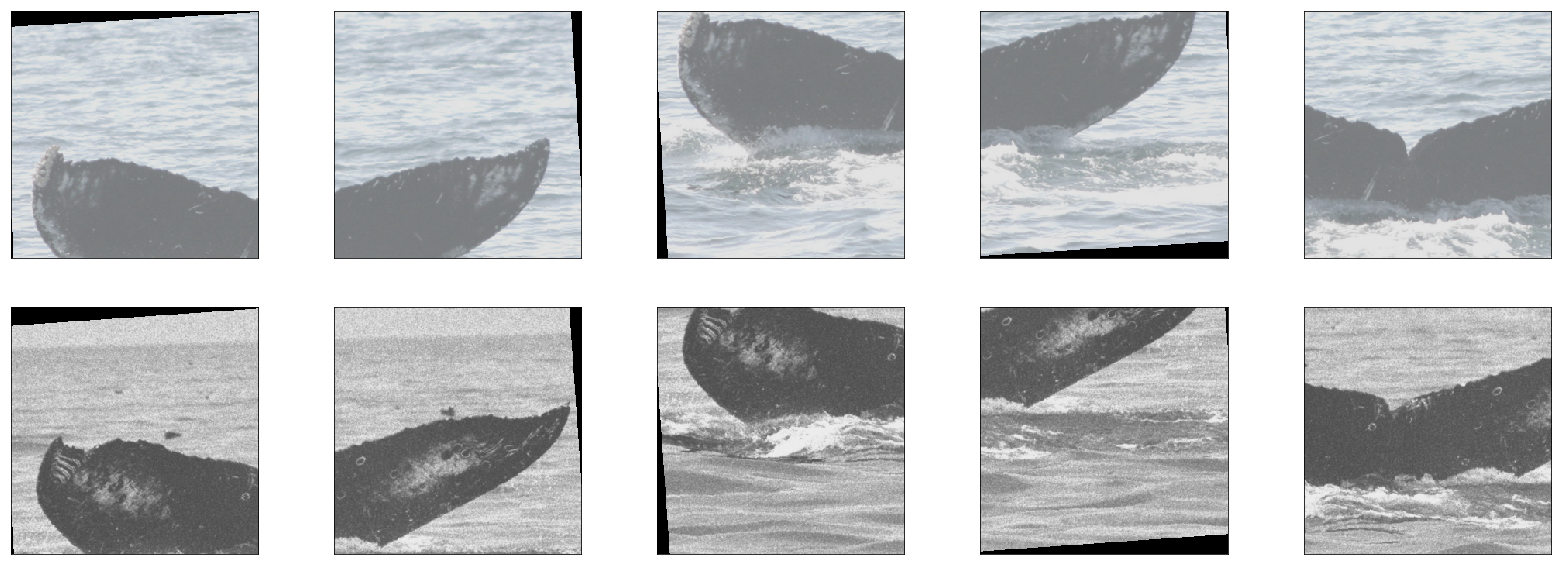

In [6]:
# Check data
img1, img2, label = iter(data_loader).next()

# 5 cropped images
print(img1.size())
bs, ncrops, c, h, w = img1.size()
# 1 item of the batch
imgs_1 = img1[0].numpy()
imgs_2 = img2[0].numpy()
f = plt.figure(figsize=(28, 10))
# For each crop
for idx in range(5):
    ax1 = f.add_subplot(2, 5, idx + 1, xticks=[], yticks=[])
    ax2 = f.add_subplot(2, 5, idx + 6, xticks=[], yticks=[])
    
    ax1.imshow(np.transpose(imgs_1[idx], (1, 2, 0)))
    ax2.imshow(np.transpose(imgs_2[idx], (1, 2, 0)))
print(label)


In [8]:

# Dataloader
data_loader = DataLoader(whale_dataset,
                         batch_size=32,
                         shuffle=True
                         )

In [9]:
whale_dataset.set_mode("train")
print(len(data_loader))

314812


In [11]:
whale_dataset.set_mode("test")
print(len(data_loader))

78703


#### Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Building and Training a Model

Model from the ground

The model will consist of a feture extrator for the whale pictures.

In [10]:
import torch
from torch import nn
from torch import optim
import torch.functional as F
from tqdm import tqdm

In [13]:
# Model
class WhaleSimilarity(nn.Module):
    """
    Network defining class.
    """
    def __init__(self):
        super(WhaleSimilarity, self).__init__()
        # Sequence of Convolution + Maxpool Layers
        self.features = nn.Sequential(nn.Conv2d(3, 8, 3, padding=1),  # sees 320x320x3 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(8, 16, 3, padding=1),  # sees 160x160x8 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(16, 32, 3, padding=1),  # sees 80x80x16 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(32, 48, 3, padding=1),  # sees 40x40x32 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(48, 64, 3, padding=1),  # sees 20x20x48 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(64, 32, 1),  # sees 10x10x64 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2)  # outputs 5x5x32 tensor
                                     )
        # Linear layer with sigmoid
        self.fc = nn.Linear(32 * 5 * 5, 1)
        
    def forward(self, x1, x2):
        # Sequence of convolutional and max pooling layers
        x1 = self.features(x1)
        x2 = self.features(x2)
        
        # Flatten result
        x1 = x1.view(-1, 32 * 5 * 5)
        x2 = x2.view(-1, 32 * 5 * 5)
        
        # Subtrack results
        x = torch.abs(x1 - x2)
        # Linear neuron
        x = self.fc(x)
        
        return x
    

In [12]:
# check if CUDA is available
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

if train_device == 'cpu':
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
# Defines Model
model = WhaleSimilarity()

model.to(train_device)

WhaleSimilarity(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (16): ReLU()
   

In [16]:
# Specify loss function (Binary Cross-entropy)
criterion = nn.BCELoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss
# model = model.to(train_device).double()
for epoch in range(1, n_epochs + 1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    # Training 
    print("Training Model...")
    whale_dataset.set_mode("train")
    for img1, img2, target in tqdm(data_loader):
        # move tensors to GPU if CUDA is available
        img1, img2, target = img1.to(train_device), img2.to(train_device), target.to(train_device).float()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Compesate 5 Crop
        bs, ncrops, c, h, w = img1.size()
        img1 = img1.view(-1, c, h, w)
        img2 = img2.view(-1, c, h, w)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(img1, img2)
        # Mean result of 5 crops
        output = output.view(bs, ncrops, -1).mean(1)
        # calculate the batch loss
        loss = criterion(output, target.view(-1, 1))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * bs
        
    ######################    
    # validate the model #
    ######################
    print("Validating Resulst...")
    whale_dataset.set_mode("test")
    # Deal with corrupted file
    for data, target in tqdm(data_loader):
        # move tensors to GPU if CUDA is available
        img1, img2, target = img1.to(train_device), img2.to(train_device), target.to(train_device).float()
        # Compesate 5 Crop
        bs, ncrops, c, h, w = img1.size()
        img1 = img1.view(-1, c, h, w)
        img2 = img2.view(-1, c, h, w)
        
        output = model(img1, img2)
        
        # Mean result of 5 crops
        output = output.view(bs, ncrops, -1).mean(1)
        # calculate the batch loss
        loss = criterion(output, target.view(-1, 1))
        # update average validation loss 
        valid_loss += loss.item() * bs
    
    # calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(test_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_whales.pt')
        valid_loss_min = valid_loss
    
    # Scheduler step
    scheduler.step(valid_loss)

Training Model...


  0%|                                                                          | 19/314812 [01:44<454:25:24,  5.20s/it]

Using transfer learning as features extractors.

In [ ]:
# Load Pretrained Models

resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)

alexnet = models.alexnet(pretrained=True)

squeezenet = models.squeezenet1_0(pretrained=True)

vgg16 = models.vgg19(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

densenet121 = models.densenet121(pretrained=True)
densenet161 = models.densenet161(pretrained=True)

inception3 = models.inception_v3(pretrained=True)

In [ ]:
# Add attributes to models
resnet152.name = 'ResNet_152'
resnet152.last_layer_attr = 'fc'

vgg19.name = 'VGG_19'
vgg19.last_layer_attr = 'classifier'

densenet161.name = 'DenseNet_161'
densenet161.last_layer_attr = 'classifier'

# List of Models and its last layer
transfer_models = [resnet152,
                    vgg19,
                    densenet161]